In [55]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

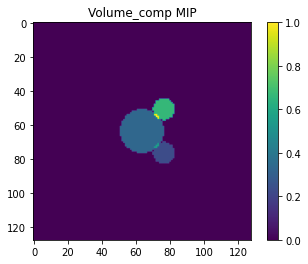

In [57]:
nx = 128
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, X, Y, Z, _, _, _ = volume_fourier(jnp.fft.ifftshift(vol), dimensions)

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

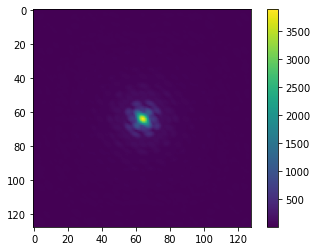

In [58]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

Get the grids and mask

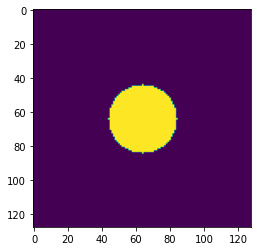

In [62]:
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# Important thast the grids are not jax (aka Tracer)  objects
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

radius = 1
mask = create_mask(X, Y, Z , (0,0,0),radius)

mip_z(jnp.fft.fftshift(mask))

Generate projections (in Fourier domain)

In [63]:
@jax.jit
def slice_func(v, angles):
    projection, _ = project(mask * v, x_grid, y_grid, z_grid, angles)
    return projection

@jax.jit
def slice_func_array(v, angles):    
    return jax.vmap(slice_func, in_axes = (None, 0))(v, angles)

In [66]:
N = 1000
angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true)
print(time.time()-start)

0.0002758502960205078


In [67]:
imgs.shape

(1000, 16384)

In [95]:
np.sum(mask[0])

DeviceArray(1257., dtype=float64)

Loss function given volume and angles, for one image and for many (batches of images). We have a separate loss function for each angles-image pair.

In [97]:
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, img):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    return 1/(2* 1257) * l2sq(slice_func(v, angles) - img)   #1257 = number of pixels in mask at z=0


@jax.jit
def loss_func_batched(v, angles, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0))(v, angles, imgs)

And the gradients of the above, with respect to angles

In [69]:
@jax.jit
def grad_loss_angles(v, angles, img):
    return jax.grad(loss_func, argnums = 1)(v, angles, img)

@jax.jit
def grad_loss_angles_batched(v, angles, imgs):
    return jax.vmap(grad_loss_angles, in_axes = (None, 0, 0))(v, angles, imgs)

In [73]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(ll.shape)

0.0002658367156982422
(1000,)


In [74]:
start = time.time()
dl = grad_loss_angles(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(dl.shape)

0.00417327880859375
(3,)


In [75]:
start = time.time()
dl = grad_loss_angles_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(dl.shape)

0.00040912628173828125
(1000, 3)


Gradients with respect to volume pixels, over all (or a batch of) images

In [76]:
@jax.jit
def grad_loss_volume(v, angles, img):
    return jax.grad(loss_func)(v, angles, img)

@jax.jit
def grad_loss_volume_batched(v, angles, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0))(v, angles, imgs), axis=0)

In [77]:
start = time.time()
ll = grad_loss_volume(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(ll.shape)

1.1819477081298828
(128, 128, 128)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [79]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vol_fourier, angles_true[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

0.003928184509277344
(128, 128, 128)


## Gradient descent with respect to angles

In [80]:
alpha = 0.00000001
a = jnp.array(np.random.rand(N, 3)*np.pi*2)
a = jnp.mod(a, 2*jnp.pi)
#a = angles_true + 0.01*a
N_iter = 10

for i in range(N_iter):
        
    if jnp.mod(i,100) == 0:
    #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(vol_fourier, a, imgs))))
        
    a = a - alpha * jnp.conj(grad_loss_angles_batched(vol_fourier, a, imgs))
    
a = jnp.mod(a, 2*jnp.pi)


    
max_err = jnp.mean(jnp.abs(a - angles_true))
print("mean(a-a_true) = " + str(max_err))

Iter 0: mean loss = 3996.520707484507
mean(a-a_true) = 2.1432977614670032


In [81]:
max_err = jnp.max(jnp.abs(a - angles_true))
print("max(a-a_true) = " + str(max_err))

max(a-a_true) = 6.2041021560812935


## Gradient descent with respect to volume

In [82]:
nx

128

In [85]:

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))*jnp.max(jnp.abs(imgs[0])) * mask
#v0 = vol_fourier + 0.1*v * mask
alpha = 1000000 # this alpha works well for full 128 x 128 x 128 volume with mask
#alpha = 0.1
batch_size = 2
N_iter = 1000 * 20
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

Iter 0: mean loss = 367534.34269744484
Iter 100: mean loss = 215608.81684598525
Iter 200: mean loss = 178019.84676411815
Iter 300: mean loss = 129931.22230051452
Iter 400: mean loss = 92456.93401099744
Iter 500: mean loss = 76837.1732086603
Iter 600: mean loss = 60855.72168513095
Iter 700: mean loss = 47783.73888952151
Iter 800: mean loss = 44626.02049111101
Iter 900: mean loss = 32442.050520794353
Iter 1000: mean loss = 33295.321877033835
Iter 1100: mean loss = 23586.14541477875
Iter 1200: mean loss = 20166.819658577173
Iter 1300: mean loss = 18862.265391552297
Iter 1400: mean loss = 14114.112291069137
Iter 1500: mean loss = 11827.23705223911
Iter 1600: mean loss = 13052.280148118483
Iter 1700: mean loss = 11047.738441016601
Iter 1800: mean loss = 9695.625895431738
Iter 1900: mean loss = 7187.3920810741165
Iter 2000: mean loss = 7846.880058435558
Iter 2100: mean loss = 7696.870510825921
Iter 2200: mean loss = 7223.6300211955095
Iter 2300: mean loss = 6114.197852836993
Iter 2400: mean 

In [149]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v*mask - vol_fourier*mask)/jnp.max(vol_fourier*mask))))

Final loss function (over all data) =  21.74200198240629
Relative error =  0.08583149878744693


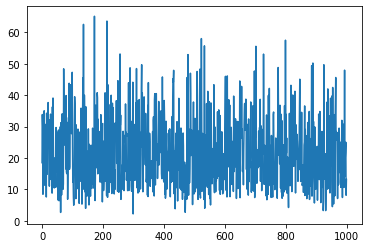

In [150]:
loss_imgs = loss_func_batched(v, angles_true, imgs)
plt.plot(loss_imgs)

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

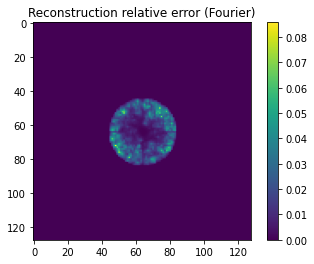

In [134]:
mip_z(jnp.abs(jnp.fft.fftshift((v*mask-vol_fourier*mask)/jnp.max(vol_fourier*mask))));plt.colorbar()
plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

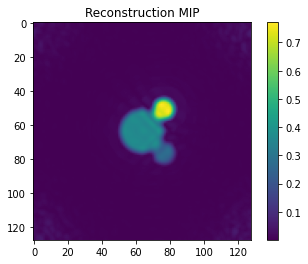

In [135]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

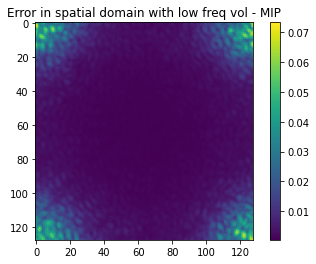

In [142]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

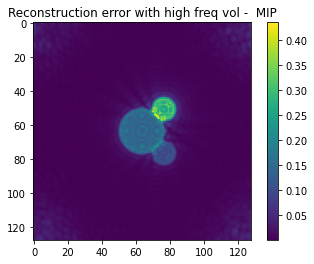

In [143]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')